<a href="https://colab.research.google.com/github/chivy-debug/Detect_SQL-Injection-XSS_Using_ML-DL/blob/main/Detect_SQL_Injection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import thư viện
import re
import pandas as pd
import numpy as np
from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Tải dataset
df = pd.read_csv("/content/Modified_SQL_Dataset.csv")

In [5]:
# Hàm rút trích đặc trưng từ Query
def extract_sql_features(query):
    features = {}

    if not isinstance(query, str):
        # Xử lý trường hợp query không phải string
        for feature_name in [
            'length', 'whitespace_count', 'dangerous_keywords', 'single_quotes', 'double_quotes',
            'backticks', 'comment_markers', 'semicolons', 'special_chars', 'logical_operators',
            'dangerous_functions', 'information_schema', 'table_name', 'column_name', 'version_query',
            'database_query', 'time_based', 'file_access', 'group_concat', 'union_select',
            'type_conversion', 'hex_encoding', 'excessive_whitespace', 'stacked_queries',
            'comment_termination', 'boolean_blind'
        ]:
            features[feature_name] = 0
        return features

    query = query.lower()  # Chuyển về chữ thường

    # 1. Độ dài của câu SQL
    features['length'] = len(query)

    # 2. Số lượng khoảng trắng
    features['whitespace_count'] = query.count(" ")

    # 3. Số lượng từ khóa SQL nguy hiểm
    dangerous_keywords = [
        "select", "union", "drop", "insert", "delete", "update", "alter",
        "create", "truncate", "exec", "waitfor", "declare"
    ]
    features['dangerous_keywords'] = sum(query.count(keyword) for keyword in dangerous_keywords)

    # 4. Dấu nháy
    features['single_quotes'] = query.count("'")
    features['double_quotes'] = query.count('"')
    features['backticks'] = query.count("`")

    # 5. Dấu comment và chấm phẩy
    features['comment_markers'] = query.count("--") + query.count("/*") + query.count("*/")
    features['semicolons'] = query.count(";")

    # 6. Ký tự đặc biệt
    special_chars = ['=', '(', ')', '<', '>', '|', '&', '%', '*', '+', '$', '#', '@', '!']
    features['special_chars'] = sum(query.count(char) for char in special_chars)

    # 7. Toán tử logic
    logical_operators = [" or ", " and ", " xor ", " not ", "||", "&&"]
    features['logical_operators'] = sum(1 for op in logical_operators if op in query)

    # 8. Các hàm SQL nguy hiểm
    sql_functions = [
        "char(", "concat(", "substring(", "ascii(", "hex(", "unhex(", "length(",
        "extractvalue(", "updatexml(", "mid(", "ord(", "chr("
    ]
    features['dangerous_functions'] = sum(query.count(func) for func in sql_functions)

    # 9-13. Các đặc trưng dò tìm thông tin
    features['information_schema'] = 1 if "information_schema" in query else 0
    features['table_name'] = 1 if "table_name" in query else 0
    features['column_name'] = 1 if "column_name" in query else 0
    features['version_query'] = 1 if "version" in query or "@@version" in query else 0
    features['database_query'] = 1 if "database()" in query or "schema()" in query else 0

    # 14. Kỹ thuật tấn công dựa trên thời gian
    time_based = ["sleep(", "benchmark(", "pg_sleep(", "waitfor delay", "generateSeries("]
    features['time_based'] = sum(1 for func in time_based if func in query)

    # 15. Truy cập file hệ thống
    file_access = ["load_file(", "into outfile", "into dumpfile", "load data infile"]
    features['file_access'] = sum(1 for func in file_access if func in query)

    # 16-17. Kỹ thuật trích xuất dữ liệu
    features['group_concat'] = 1 if "group_concat(" in query else 0
    features['union_select'] = 1 if "union" in query and "select" in query else 0

    # 18. Kỹ thuật bypass kiểm tra kiểu dữ liệu
    cast_convert = ["cast(", "convert("]
    features['type_conversion'] = sum(1 for func in cast_convert if func in query)

    # 19. Mã hóa hex
    hex_encoding = ["%23", "%27", "%3D", "%20", "%22", "%2D"]
    features['hex_encoding'] = sum(query.count(enc) for enc in hex_encoding)

    # 20. Nhiều khoảng trắng bất thường
    features['excessive_whitespace'] = 1 if re.search(r'\s{3,}', query) else 0

    # Thêm đặc trưng mới
    # 21. Stacked queries (nhiều câu truy vấn nối tiếp)
    features['stacked_queries'] = len(re.findall(r';.*\w+', query))

    # 22. Comment termination (kỹ thuật comment phần còn lại của câu truy vấn)
    features['comment_termination'] = 1 if query.strip().endswith('--') or query.strip().endswith('#') else 0

    # 23. Boolean-based blind SQLi
    boolean_patterns = ['1=1', 'true=true', 'false=false', '1<>2', '0=0']
    features['boolean_blind'] = sum(1 for pattern in boolean_patterns if pattern in query)

    return features


# Trích xuất đặc trưng
features_df = df['Query'].apply(extract_sql_features).apply(pd.Series)

# Chuẩn bị dữ liệu đầu vào
X = features_df
y = df['Label']  # Nhãn 1 (sql_injection), 0 (legit)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Kiểm tra phân bố nhãn
print(f"Training set distribution: {np.bincount(y_train)}")
print(f"Testing set distribution: {np.bincount(y_test)}")

Training set distribution: [9107 9105]
Testing set distribution: [2277 2277]



--- Random Forest Model Evaluation ---
Accuracy: 0.996
Precision: 0.997
Recall: 0.994
F1-Score: 0.996

Classification Report:
              precision    recall  f1-score   support

           0      0.994     0.997     0.996      2277
           1      0.997     0.994     0.996      2277

    accuracy                          0.996      4554
   macro avg      0.996     0.996     0.996      4554
weighted avg      0.996     0.996     0.996      4554



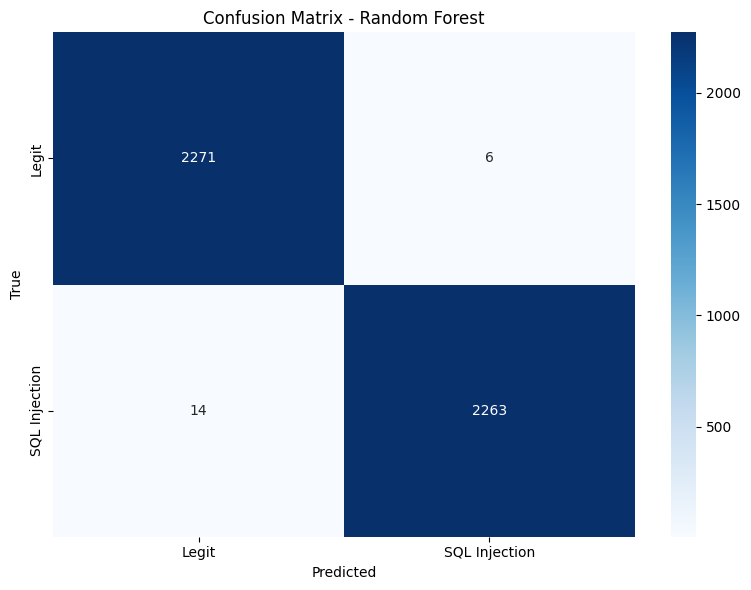

In [6]:
#Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Huấn luyện mô hình Random Forest
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)

# Đánh giá trên tập test
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- Random Forest Model Evaluation ---")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'SQL Injection'],
            yticklabels=['Legit', 'SQL Injection'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()


--- XGBoost Model Evaluation ---
Accuracy: 0.995
Precision: 0.997
Recall: 0.993
F1-Score: 0.995

Classification Report:
              precision    recall  f1-score   support

           0      0.993     0.997     0.995      2277
           1      0.997     0.993     0.995      2277

    accuracy                          0.995      4554
   macro avg      0.995     0.995     0.995      4554
weighted avg      0.995     0.995     0.995      4554



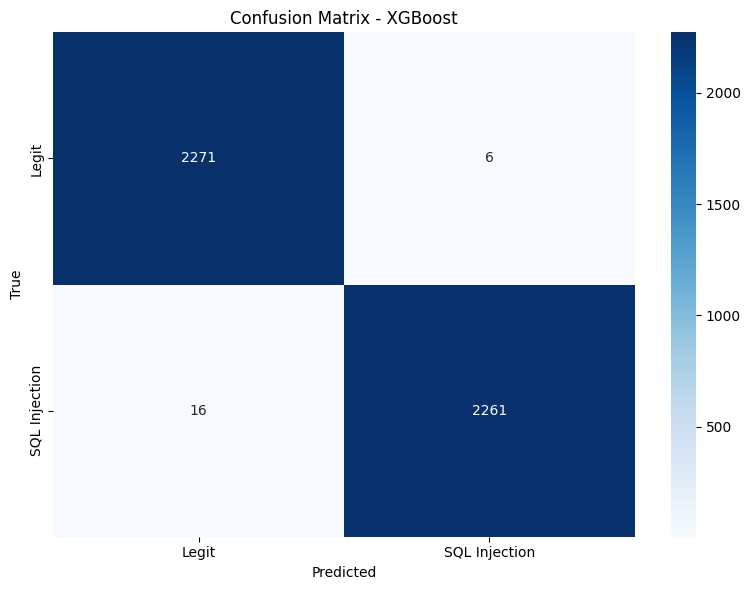

In [7]:
# XGBoost Model
from xgboost import XGBClassifier

# Huấn luyện mô hình
model = XGBClassifier(n_estimators=400, random_state=0)
model.fit(X_train, y_train)

# Đánh giá trên tập test
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- XGBoost Model Evaluation ---")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'SQL Injection'],
            yticklabels=['Legit', 'SQL Injection'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()


--- KNN Model Evaluation ---
Accuracy: 0.993
Precision: 0.993
Recall: 0.993
F1-Score: 0.993

Classification Report:
              precision    recall  f1-score   support

           0      0.993     0.993     0.993      2277
           1      0.993     0.993     0.993      2277

    accuracy                          0.993      4554
   macro avg      0.993     0.993     0.993      4554
weighted avg      0.993     0.993     0.993      4554



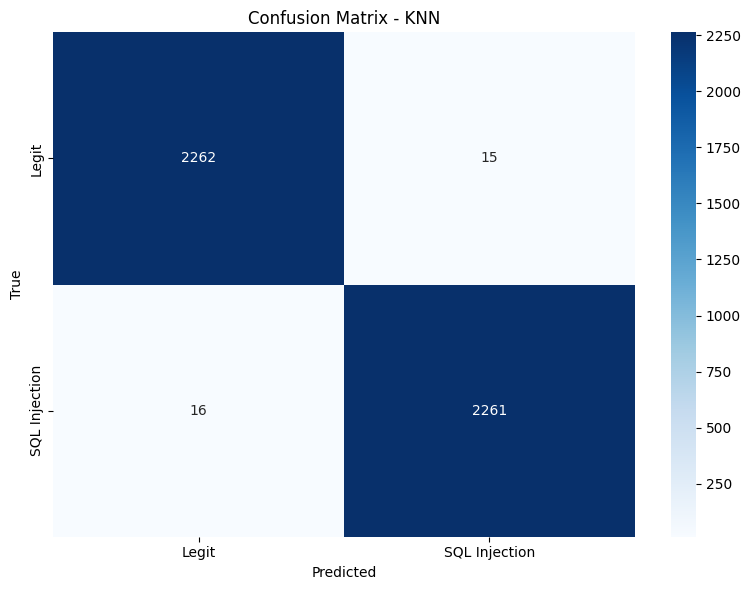

In [8]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier

# Chuẩn hóa dữ liệu (quan trọng cho KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Khởi tạo và huấn luyện mô hình KNN
k = 5  # Số lượng neighbors
model = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto')
model.fit(X_train_scaled, y_train)

# Đánh giá trên tập test
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- KNN Model Evaluation ---")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))


# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'SQL Injection'],
            yticklabels=['Legit', 'SQL Injection'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - KNN')
plt.tight_layout()
plt.savefig('knn_confusion_matrix.png')
plt.show()


--- Decision Tree Model Evaluation ---
Accuracy: 0.992
Precision: 0.996
Recall: 0.987
F1-Score: 0.992

Classification Report:
              precision    recall  f1-score   support

           0      0.987     0.996     0.992      2277
           1      0.996     0.987     0.992      2277

    accuracy                          0.992      4554
   macro avg      0.992     0.992     0.992      4554
weighted avg      0.992     0.992     0.992      4554



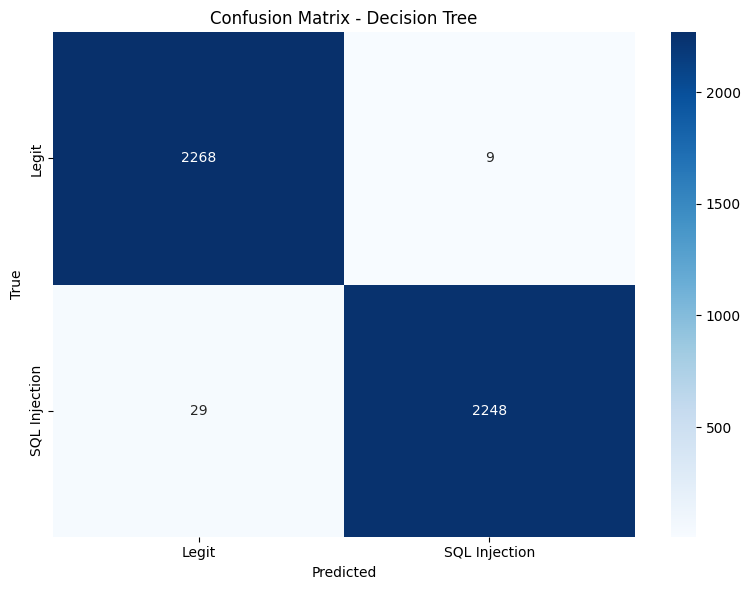

In [10]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

# Khởi tạo và huấn luyện mô hình Decision Tree
model = DecisionTreeClassifier(random_state=0, max_depth=10)  # max_depth để tránh overfitting
model.fit(X_train, y_train)

# Đánh giá trên tập test
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- Decision Tree Model Evaluation ---")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'SQL Injection'],
            yticklabels=['Legit', 'SQL Injection'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout()
plt.savefig('dt_confusion_matrix.png')
plt.show()

# Vẽ cây quyết định (nếu kích thước vừa phải)
if model.max_depth is not None and model.max_depth <= 5:
    plt.figure(figsize=(20, 10))
    tree.plot_tree(model, feature_names=features_df.columns,
                  class_names=['Legit', 'SQL Injection'],
                  filled=True, rounded=True)
    plt.title('Decision Tree Visualization')
    plt.savefig('decision_tree_visualization.png')
    plt.show()


--- SVM Model Evaluation ---
Accuracy: 0.984
Precision: 0.990
Recall: 0.977
F1-Score: 0.983

Classification Report:
              precision    recall  f1-score   support

           0      0.977     0.990     0.984      2277
           1      0.990     0.977     0.983      2277

    accuracy                          0.984      4554
   macro avg      0.984     0.984     0.984      4554
weighted avg      0.984     0.984     0.984      4554



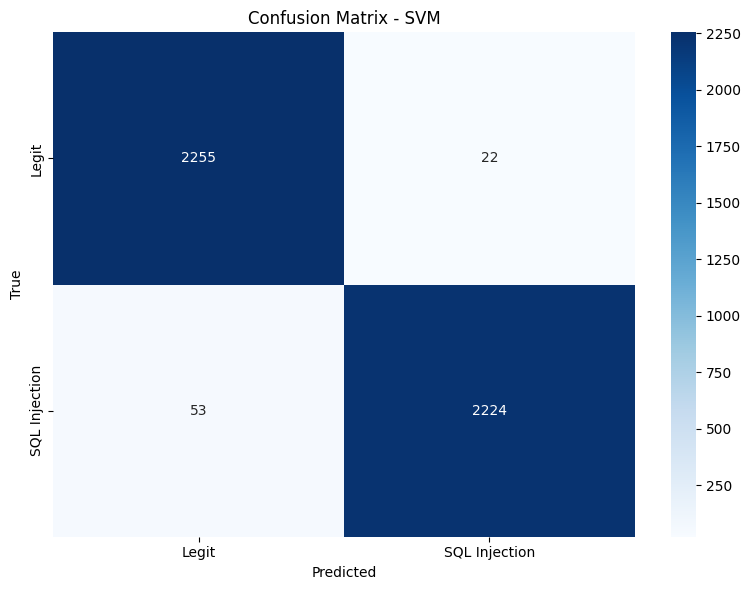

In [11]:
# SVM Model
from sklearn.svm import SVC

# Huấn luyện mô hình SVM
model = SVC(kernel='linear', random_state=0)  # Bạn có thể thay đổi kernel (linear, rbf, poly) tùy ý
model.fit(X_train, y_train)

# Đánh giá trên tập test
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- SVM Model Evaluation ---")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'SQL Injection'],
            yticklabels=['Legit', 'SQL Injection'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.tight_layout()
plt.savefig('dt_confusion_matrix.png')
plt.show()